# Mutual information with batch in IDEAS features

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load common_.py
from common import *

In [3]:
from sklearn.feature_selection import mutual_info_classif

In [15]:
samples = None
# samples = pandas.read_csv("data/selected_samples.csv")
df = e_load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"),
    samples, "Low/*.cif")
df = e_load.remove_unwanted_features(df)
df = e_load.tag_columns(df)
df = e_load.clean_column_names(df)

In [16]:
df = df[df["meta_label_coi"]]

In [17]:
df.head()

,meta_object_number,feat_area_m01,feat_area_m03,feat_area_m04,feat_area_m06,feat_area_m07,feat_area_m09,feat_area_m11,feat_area_mc,feat_aspect_ratio_m01,...,feat_intensity_m02_ch02,feat_similarity_m01_ch02_ch03,meta_timepoint,meta_replicate,meta_group,meta_label_coi,meta_label_mcp_neg_psba_pos,meta_label_mcp_pos_psba_pos,meta_label_mcp_pos_psba_neg,meta_label_mcp_neg_psba_neg
8,8,24.888889,5.222222,0.0,14.444445,17.777779,23.000000,19.444445,25.555555,0.921710,...,283.602936,2.021338,0,R1,Low,True,True,False,False,False
9,9,55.555557,8.333333,0.0,35.111111,18.666666,51.000000,25.111111,69.111115,0.357953,...,469.000000,2.211377,0,R1,Low,True,True,False,False,False
12,12,41.222221,0.000000,0.0,26.111111,26.444445,46.444443,50.888889,55.333332,0.750179,...,291.416656,0.950580,0,R1,Low,True,True,False,False,False
14,14,74.777779,9.555555,0.0,35.555557,37.777779,73.888885,50.888889,105.666664,0.603159,...,498.750000,1.147965,0,R1,Low,True,True,False,False,False
26,26,27.444445,8.444445,0.0,14.111111,19.333334,17.555555,22.000000,27.888889,0.910296,...,559.731689,1.147697,0,R1,Low,True,True,False,False,False


In [7]:
discrete_features_map = {
    'feat_Area': False,
    'feat_Aspect Ratio': False,
    'feat_Aspect Ratio Intensity': False,
    'feat_Modulation': False,
    'feat_Contrast': False,
    'feat_Gradient RMS': False,
    'feat_Intensity': False,
    'feat_Mean Pixel': False,
    'feat_Median Pixel': False,
    'feat_Max Pixel': False,
    'feat_Length': True,
    'feat_Width': True,
    'feat_Height': True,
    'feat_Bright Detail Intensity R3': False,
    'feat_Similarity': False
}

In [8]:
import re
reg = r"^(feat_[^_]+)_.+$"

In [9]:
discrete_features = df.filter(regex="feat").columns.map(lambda col: discrete_features_map[re.match(reg, col).group(1)]).values.astype("bool")

# Mutual information of features with biological replicate

We expect to see no mutual information between features and biological replicate as all replicates should be very similar.

In [8]:
n = 10000

In [9]:
mi_replicate = {}
for idx, gdf in df.groupby("meta_group"):
    indices = numpy.random.choice(len(gdf), size=n, replace=False)
    mi_replicate[idx] = mutual_info_classif(X=gdf.filter(regex="feat").iloc[indices].values, y=gdf["meta_replicate"].iloc[indices])#, discrete_features=discrete_features)

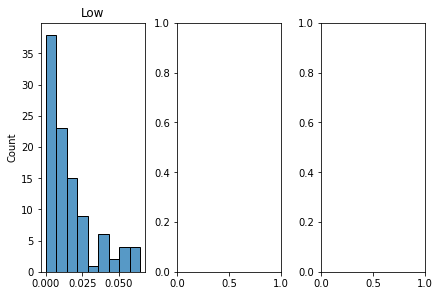

In [10]:
fig, axes = plt.subplots(1, 3, constrained_layout=True)
axes = axes.ravel()
for i, (k, v) in enumerate(mi_replicate.items()):
    axes[i].set_title(k)
    seaborn.histplot(v, ax=axes[i])

Maximal MI is in this case ~0.08. This is very low.

# Mutual information of features with timepoint

In [13]:
mi_timepoint = {}
for idx, gdf in df.groupby("meta_group"):
    indices = numpy.random.choice(len(gdf), size=n, replace=False)
    mi_timepoint[idx] = mutual_info_classif(X=df.filter(regex="feat").iloc[indices].values, y=df["meta_timepoint"].iloc[indices])

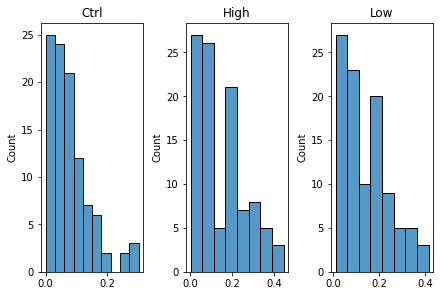

In [14]:
fig, axes = plt.subplots(1, 3, constrained_layout=True)
axes = axes.ravel()
for i, (k, v) in enumerate(mi_timepoint.items()):
    axes[i].set_title(k)
    seaborn.histplot(v, ax=axes[i])

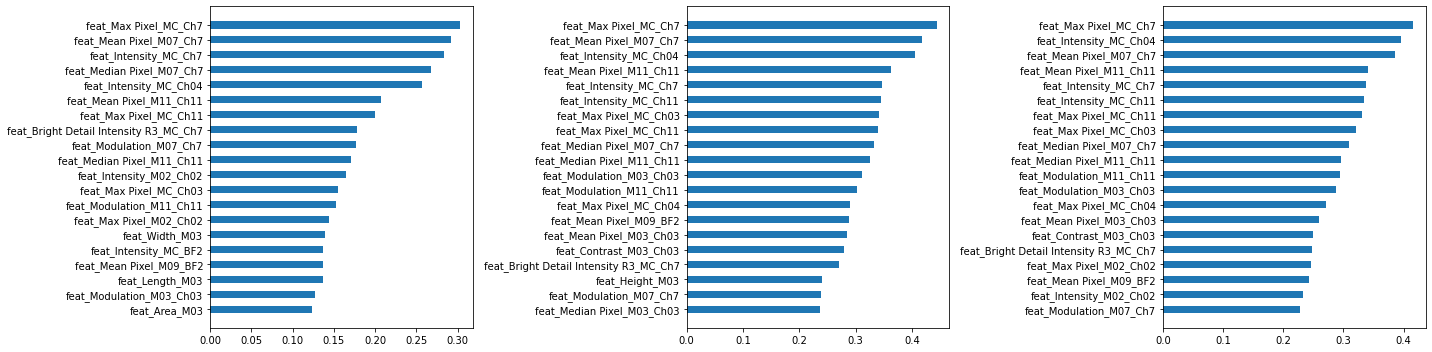

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(20,5), tight_layout=True)
axes = axes.ravel()
for i, (k, v) in enumerate(mi_timepoint.items()):
    args = numpy.argsort(v)[-20:]
    axes[i].barh(y=df.filter(regex="feat").columns[args], width=v[args], height=0.5)

All features have some mutual information with the timepoint. This is not unexpected as we expect to see changes as time progresses.

# Mutual information of features with file

In [18]:
df["meta_id"] = df["meta_group"] + df["meta_timepoint"].astype(str) + df["meta_replicate"]

In [30]:
%%time
from multiprocessing import Pool

def func(gdf):
    indices = numpy.random.choice(len(gdf), size=min(len(gdf), n), replace=False)
    return mutual_info_classif(X=gdf.filter(regex="feat").iloc[indices].values, y=gdf["meta_id"].iloc[indices])

with Pool(processes=8) as pool:
    promises = [(idx, pool.apply_async(func, args=(gdf,))) for idx, gdf in df.groupby("meta_id")]
    
    res = []
    for idx, p in promises:
        res.append((idx, p.get()))
        print(idx, end=" ")

Low0R1 Low0R2 Low0R3 Low11R1 Low11R2 Low11R3 Low12R1 Low12R2 Low12R3 Low13R1 Low13R2 Low13R3 Low14R1 Low14R2 Low14R3 Low15R1 Low15R2 Low15R3 Low16R1 Low16R2 Low16R3 Low1R1 Low1R2 Low1R3 Low2R1 Low2R2 Low2R3 Low3R1 Low3R2 Low3R3 Low4R1 Low4R2 Low4R3 Low5R1 Low5R2 Low5R3 Low6R1 Low6R2 Low6R3 Low7R1 Low7R2 Low7R3 Low8R1 Low8R2 Low8R3 Low9R1 Low9R2 Low9R3 CPU times: user 545 ms, sys: 302 ms, total: 847 ms
Wall time: 32.7 s


In [31]:
idx = [r[0] for r in res]
data = [r[1] for r in res]
mi_df = pandas.DataFrame(index=idx, data=data, columns=df.filter(regex="feat").columns)

(-1.0, 103.0)

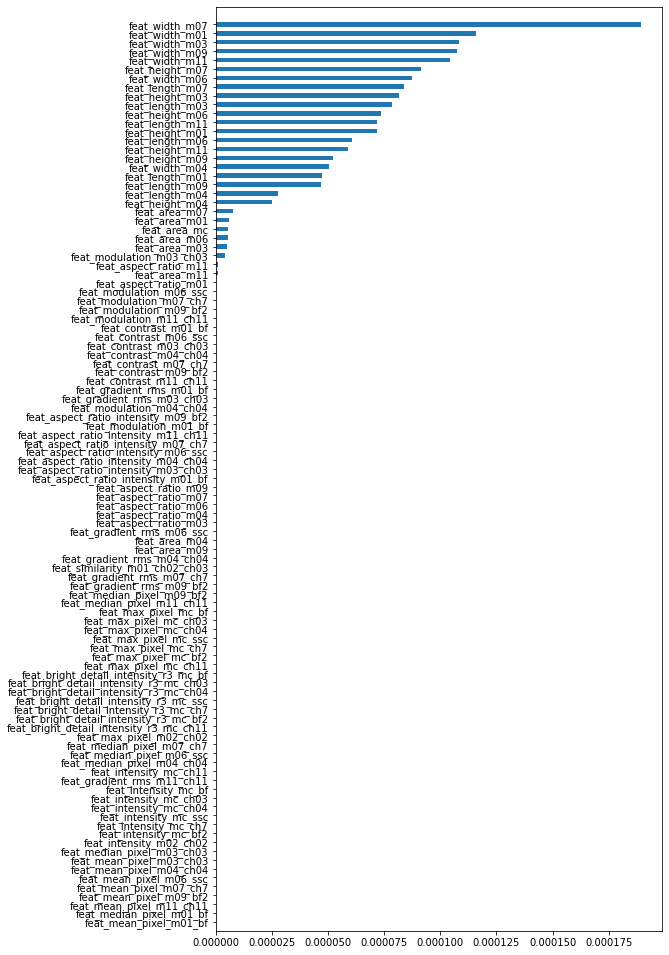

In [62]:
fig, ax  = plt.subplots(figsize=(8,17))
s = numpy.argsort(mi_df.mean())
pos = numpy.arange(len(mi_df.columns))
ax.barh(y=pos, width=mi_df.mean()[s], height=0.5, tick_label=mi_df.columns[s])
ax.set_ylim(-1, len(mi_df.columns)+1)